In [36]:
# in this notebook, I'm attempting to track down the error in the adaptive timestep.
# why is it creating such a tiny timestep?

In [37]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# SET UP (scaled down) GRID ARRAYS
dx = 1
x = np.arange(0, 10, dx)

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:5] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[5:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:5] = 0.0001
k_sed = np.zeros(len(x))
k_sed[5:] = 0.001

In [39]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / (c*q[-1])  # time-step size

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        # calc grain attrition
        # atr = beta_ig[1:] * qs[1:]
        atr = 0.000004 * qs[1:]
        
        # calc change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0
        
        # track total erosion
        total_ero = bedrock_ero - sedimentation_rate
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # set adaptive timestep
        # first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        valid_places = np.where(ero_diff < 0)
        times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        
        # then check time to deplete all sediment
        sed_depletion_locations = np.where(sedimentation_rate < 0)
        times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])

        # check for smaller condition
        if np.min(times_to_flat) <= np.min(times_to_no_sed):
            dt = 0.2 * np.min(times_to_flat)
            
        else:
            dt = 0.2 * np.min(times_to_no_sed)
        
    print("slope: ", S, "\n")
    print("sed flux: ", qs, "\n")
    print("efac: ", efac, "\n")
    print("topography: ", eta, "\n")
    print("bedrock: ", etab, "\n")
    print("igneous plucking rate: ", ero_plucking_ig, "\n")
    print("sedimentary plucking rate: ", ero_plucking_sed, "\n")
    print("igneous abrasion rate: ", ero_ab_ig, "\n")
    print("sedimentary abrasion rate: ", ero_ab_sed, "\n")
    print("bedrock erosion rate: ", bedrock_ero, "\n")
    print("attrition: ", atr, "\n")
    print("sedimentation rate: ", sedimentation_rate, "\n")
    print("sediment: ", H, "\n")
    print("total erosion rate: ", total_ero, "\n")
    print("elevaion differences: ", elev_diff, "\n")
    print("erosion rate differences: ", ero_diff, "\n")
    print("location of negative erosion rates: ", valid_places, "\n")
    print("times to flat: ", times_to_flat, "\n")
    print("times to no sed: ", times_to_no_sed, "\n")
    print("timestep: ", dt, "\n")
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, elev_diff, ero_diff, valid_places, times_to_flat, 
            times_to_no_sed, dt)

In [40]:
(S, 
qs, 
efac, 
eta, 
etab, 
ero_plucking_ig, 
ero_plucking_sed,
ero_ab_ig,
ero_ab_sed,
bedrock_ero, 
atr, 
sedimentation_rate, 
H, 
total_ero,
elev_diff, 
ero_diff, 
valid_places, 
times_to_flat,
times_to_no_sed,
dt) = two_lith_one_sed(x,
                       dx,
                       Hstar,
                       H,
                       etab,
                       eta,
                       beta_ig,
                       beta_sed,
                       k_ig,
                       k_sed,
                       num_steps = 6)

slope:  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.74700271e-16
  2.29488650e-12  1.92943758e-09  2.63063119e-07  5.81745695e-06
  2.16979467e-05] 

sed flux:  [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  9.47422978e-16  7.25322469e-12  7.31782297e-09  1.16401323e-06
  2.94186278e-05  1.23437096e-04] 

efac:  [0.36787944 0.36787944 0.36787944 0.36787944 0.36787944 0.36787944
 0.36787945 0.36788042 0.36790181 1.        ] 

topography:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.71844785e-16 -2.38956077e-12 -1.94665271e-09 -2.65359304e-07
 -6.08366464e-06 -2.77803985e-05] 

bedrock:  [-1.00000000e-01 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01
 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01
 -1.00000002e-01 -2.77803985e-05] 

igneous plucking rate:  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  5.51378105e-20
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00] 

sedimentary pl

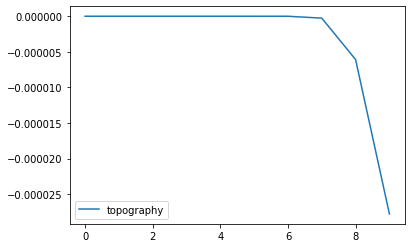

In [41]:
plt.plot(x, eta, label = 'topography')
# plt.plot(x, etab, label = 'bedrock')
# plt.plot(x, H, label = 'sediment')
plt.legend()

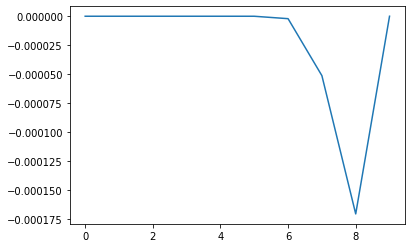

In [42]:
plt.plot(x, total_ero)